<center><h1> Análisis sobre remises y taxis - Municipalidad de Córdoba</h1></center>

La idea es realizar un análisis rapido sobre taxis y remises en el ambito de la ciudad de Córdoba. Utilizamos los datos que figuran en el portal de datos abiertos del gobierno municipal ([datos](https://gobiernoabierto.cordoba.gob.ar/data/datos-abiertos/categoria/taxis-y-remis))
* <a class="buttom" href="#los_datos">Datos: Descarga</a> <br>
* <a class="buttom" href="#curado">Datos: Pre-Procesamiento</a> <br>
* <a class="buttom" href="#curadoB">Datos: Pre-Procesamiento II</a> <br>
* <a class="buttom" href="#analisis">Datos: Análisis</a> <br>

El procesamiento depende de las librerias:

In [1]:
# libs
## gen
import os
import glob as glb
## num
import numpy as np
import pandas as pd
## viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Para el paso de las tablas a png requiere : wkhtmltopdf, y
import imgkit

<a id='los_datos'></a>

## Datos: Descarga

Al momento de realizar al análisis se descargan los archivos (la pagina indica actualizacion a demanda y debajo de esta indicacion menciona: *Taxis habilitados en tiempo real. Estos recursos estan conectados a nuestra base de datos*): *lista-remises.csv* y *lista-taxi.csv* disponibles en 
- https://gobiernoabierto.cordoba.gob.ar/transporte-publico/



In [2]:
f2d=['https://gobiernoabierto.cordoba.gob.ar/transporte-publico/lista-remises.csv','https://gobiernoabierto.cordoba.gob.ar/transporte-publico/lista-taxis.csv']
# Descargamos la info 
# Si dw==True
dw=False
if dw:
    for f in f2d:
        !wget  $f
    if not os.path.isdir('data'):
        os.mkdir('data')
        print('Se creo el directorio "data"')
    !cp *.csv 'data'
    !rm *.csv
if not os.path.isdir('img'):
    os.mkdir('img')
    print('Se creo el directorio "img"')
# Veamos que obtuvimos
csv_list=glb.glob('data/*lista*.csv'); csv_list.sort()
print('#######################################################')
print('##################### ARCHIVOS ########################')
print('Se obtuvieron un total de {} archivos'.format(len(csv_list)))

#######################################################
##################### ARCHIVOS ########################
Se obtuvieron un total de 2 archivos


<a id='curado'></a>

## Pre-Procesamiento

### Unimos los DataFrames

Cargamos el par de csvs y verificamos consistencia en las columnas para mergearlos.

In [3]:
clase=['remis','taxi']
pd_list = []; lst_len = []
for ic,csv_c in enumerate(zip(csv_list,clase)):
    csv,c=csv_c
    pd_tempi=pd.read_csv(csv)
    pd_tempi['clase']=c
    lst_len.append([ic,c,len(pd_tempi)])
    pd_list.append(pd_tempi)
    
# assert columnas
if all(pd_list[0].columns==pd_list[1].columns):
    pd_cat_raw=pd.concat(pd_list,axis=0,ignore_index=True)
    print(pd_cat_raw.head(5))
else:
    'Check Columnas'

                    Titular        CUIT Patente      Marca   Modelo   Año  \
0    OVEJEROS EDUARDO CESAR  12407195.0  HTF942  Chevrolet    Corsa  2009   
1     GONZALEZ EDMUNDO LUIS  17025493.0  OQK656  Chevrolet  Classic  2015   
2     NIEVA EDUARDO ALBERTO  22562430.0  NEX746       FIAT    Siena  2013   
3  FERREYRA PABLO SEBASTIAN  29449210.0  OAS345  Chevrolet  Classic  2014   
4      CORDOBA CARLOS RUBEN  17533044.0  PET958  Chevrolet  Classic  2015   

       estado  clase  
0  Habilitado  remis  
1  Habilitado  remis  
2  Habilitado  remis  
3  Habilitado  remis  
4  Habilitado  remis  


<a id='curadoB'></a>

## Pre-Procesamiento II

Antes de pasar al análisis, vamos a dejar ciertos comentarios en relacion a los datos. Tenemos (aparentes):
- Faltantes
- Errores en la carga
- etc

**La intencion de esto es que la gente de gobiernoabierto@cordoba.gov.ar pueda revisar estos casos (y actualizar la data cuando corresponda).**

#### Sumario e información general

Observamos que la columna perteneciente a CUIT parece ser DNI (esto es consistente con lo observado en https://www.cordoba.gob.ar/ciudad/movilidad/buscador-taxis-remises/)
![api](img/api_taxis_remises_muncba.png)

In [4]:
## Veamos si tenemos nulos o similares
pd_cat_raw.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6776 entries, 0 to 6775
Data columns (total 8 columns):
Titular    6775 non-null object
CUIT       6775 non-null float64
Patente    6776 non-null object
Marca      6776 non-null object
Modelo     6776 non-null object
Año        6776 non-null int64
estado     6776 non-null object
clase      6776 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 423.6+ KB


A partir del desglose anterior podemos observar que tenemos 6776 entradas (remises + taxis) y en los campos:
- Titular: Tenemos un valor no asignado
- CUIT: Tenemos un valor no asignado

In [5]:
#### Titular
print('Titular NULL')
pd_cat_raw[pd_cat_raw.Titular.isnull()]

Titular NULL


,Titular,CUIT,Patente,Marca,Modelo,Año,estado,clase
1374,NaN,32281702.0,SIN ASIGNAR,Chevrolet,Classic,2010,Habilitado,remis


In [6]:
#### CUIT
print('CUIT NULL')
pd_cat_raw[pd_cat_raw.CUIT.isnull()]

CUIT NULL


,Titular,CUIT,Patente,Marca,Modelo,Año,estado,clase
1375,ALONSO FERRERO NESTOR ANDR,NaN,DWU780,Chevrolet,Corsa,2001,Habilitado,remis


In [7]:
# Algunos estadisticos para los casos numericos
pd_cat_raw.describe()

,CUIT,Año
count,6.775000e+03,6776.000000
mean,7.898040e+11,2012.199675
std,6.500751e+13,24.603569
min,0.000000e+00,0.000000
25%,1.224464e+07,2011.000000
50%,1.753019e+07,2013.000000
75%,2.410726e+07,2015.000000
max,5.350794e+15,2018.000000


Observamos que:
- CUIT: valor minimo en 0 y valor maximo >10^15
- Año: valor minimo en 0

Estas dos instancias deben ser un error en la carga.

In [8]:
#### CUIT
print('CUIT 0 or >10^15')
pd_cat_raw[np.logical_or(pd_cat_raw.CUIT==0,pd_cat_raw.CUIT>10**15)]

CUIT 0 or >10^15


,Titular,CUIT,Patente,Marca,Modelo,Año,estado,clase
2754,AMERICAN SERVICE,0.000000e+00,TEX398,Ford,Galaxy,1994,Habilitado,remis
3871,ARCE AGOSTINA (ADM JUD GAITE ELIANA),5.350794e+15,JDG592,Chevrolet,Corsa,2010,Habilitado,taxi


In [9]:
#### Año
print('Año 0')
pd_cat_raw[pd_cat_raw['Año']==0]

Año 0


,Titular,CUIT,Patente,Marca,Modelo,Año,estado,clase
4805,BERTA MARIA SOL,28854703.0,OGU039,Chevrolet,Classic,0,Habilitado,taxi


In [10]:
# Observamos algunas restantes
# Marca
pd_cat_raw.Marca.unique()

array(['Chevrolet', 'FIAT', 'Fiar', 'Volkswagen', 'Renault', 'Peugeot',
       'Toyota', 'Ford', 'Citroën', 'Suzuki', 'Chery', 'Desconocido',
       'Mercedes Benz'], dtype=object)

Tenemos un par de situaciones:
- Fiar: pareceria ser FIAT
- Desconocido: No queda claro, porque no figuraria esta informacion...

In [11]:
#### Marca: Fiar
print('Marca Fiar')
pd_cat_raw[pd_cat_raw.Marca=='Fiar']

Marca Fiar


,Titular,CUIT,Patente,Marca,Modelo,Año,estado,clase
6,CABRERA CARLOS SALVADOR,14409601.0,AC556OM,Fiar,Cronos,2018,Habilitado,remis
45,GONZALEZ CRISTOBAL TIMOTEO,7977228.0,AC687WX,Fiar,Cronos,2018,Habilitado,remis
832,SALLITTO DANIEL ENRIQUE,17154373.0,AC795CI,Fiar,Cronos,2018,Habilitado,remis
959,RUIZ DIEGO HERNAN,24471197.0,AC886NY,Fiar,Cronos,2018,Habilitado,remis
1062,SPACHESI GUSTAVO GABRIEL,23451313.0,AC662TQ,Fiar,Cronos,2018,Habilitado,remis
1111,PEREZ SERGIO ALEJANDRO,14894139.0,AC783CZ,Fiar,Cronos,2018,Habilitado,remis
1457,CEJAS HUGO ALBERTO,16741770.0,AC710QF,Fiar,Cronos,2018,Habilitado,remis
1572,ROLDAN CARLOS OSCAR,14707821.0,AC323HJ,Fiar,Cronos,2018,Habilitado,remis
1833,LUDUEÑA CARLOS GUSTAVO,20784098.0,AC868UA,Fiar,Cronos,2018,Habilitado,remis
2048,MORALES CARLOS ALBERTO,16293022.0,AC776FS,Fiar,Cronos,2018,Habilitado,remis


Por el modelo queda claro que son FIAT (Quizas al momento de carga sea necesario algun esquema de seleccion y no de escritura...)

In [12]:
#### Marca: Desconocido
print('Marca Desconocido')
pd_cat_raw[pd_cat_raw.Marca=='Desconocido']

Marca Desconocido


,Titular,CUIT,Patente,Marca,Modelo,Año,estado,clase
3475,MACHADO LUIS ALBERTO R.,11561915.0,NBH112,Desconocido,-,2013,Habilitado,taxi


Si se consulta por NBH112 @ https://www.rentascordoba.gob.ar/ resulta que:
- FIAT - SEDAN 4 PUERTAS - SIENA FIRE 4P 1.4MPI 8V HP BZ

En vez de estar completando quizas se podria hacer la consulta a la https://www.dnrpa.gov.ar/portal_dnrpa/ (y tener una replica de la info en la Municipalidad y otra en Rentas Provincial).

### Reemplazo de Datos

En las instancias anteriores vamos a utilizar la informacion encontrada (para el caso "Marca:Desconocida") o deducida ("Marca:Fiar")

In [13]:
# Marca
pd_cat_raw['Marca_upd']=pd_cat_raw.Marca
pd_cat_raw.loc[pd_cat_raw.Marca=='Fiar','Marca_upd']='FIAT'
pd_cat_raw.loc[pd_cat_raw.Marca=='Desconocido','Marca_upd']='FIAT'

<a id='analisis'></a>

## Análisis

### Moviles Habilitados

Existen instancias en las cuales se observan 2 titulares para una misma patente. Esto en si no constituye un problema, pero debemos descontarlos al mostrar los moviles habilitados.

Casos duplicados 17 /6776


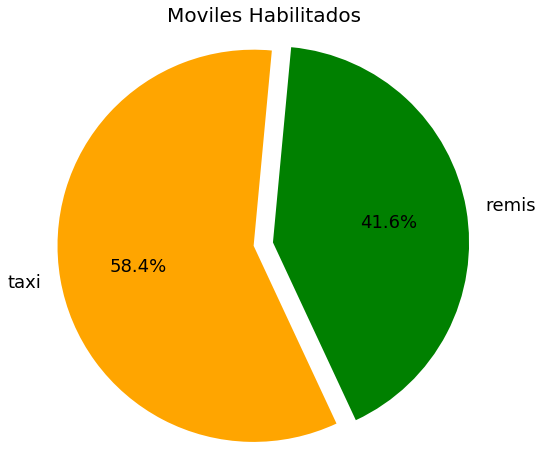

In [14]:
pd_in=pd_cat_raw[~pd_cat_raw.Patente.duplicated()].copy()
print('Casos duplicados {} /{}'.format(len(pd_cat_raw)-len(pd_in),len(pd_cat_raw)))
fig=plt.figure(figsize=(8,8))
explode = (0, 0.1)
ax=pd_in.groupby('clase')['Patente'].count().plot(kind='pie',explode=explode,fontsize=18,autopct=lambda x: '{:1.1f}%'.format(x),colors=['green','orange'],startangle=-65,shadow=False)
ax.axis('equal')
ax.set_ylabel('')
ax.set_title('Moviles Habilitados',fontsize=20)
#plt.tight_layout()
plt.savefig('img/moviles_habilitados.png')

### Antiguedad del Parque Automotor

Segun la normativa, los vehiculos son validos a partir de 2006 (Ordenanza Nº 12624 Prorroga excepcionalmente, y por única vez, hasta el 30 de Junio de 2017 inclusive, la 
vida útil de los vehículos modelo 2006...).

In [15]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)
PDF('referencias/TEX_10270.pdf',size=(1200,650))

In [16]:
pd_in['Año'].unique()

array([2009, 2015, 2013, 2014, 2018, 2012, 2011, 2010, 2017, 2016, 2008,
       2006, 2007, 2000, 2005, 2001, 2004, 1997, 2002, 1994, 1999,    0])

Observamos el caso 0, lo vamos a descartar en esta instancia (segun observamos es un unico caso)

In [17]:
pd.set_option('precision', 1)
case_cols=pd_in[pd_in['Año']>1993].groupby('clase')['Año'].describe()
summary=pd.DataFrame(case_cols.values.T,index=case_cols.columns,columns=['remis','taxi'])
summary

,remis,taxi
count,2810.0,3948.0
mean,2012.1,2012.7
std,2.9,2.7
min,1994.0,1999.0
25%,2010.0,2011.0
50%,2012.0,2013.0
75%,2014.0,2015.0
max,2018.0,2018.0


/home/felix/anaconda3/envs/datosabiertos_cba/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


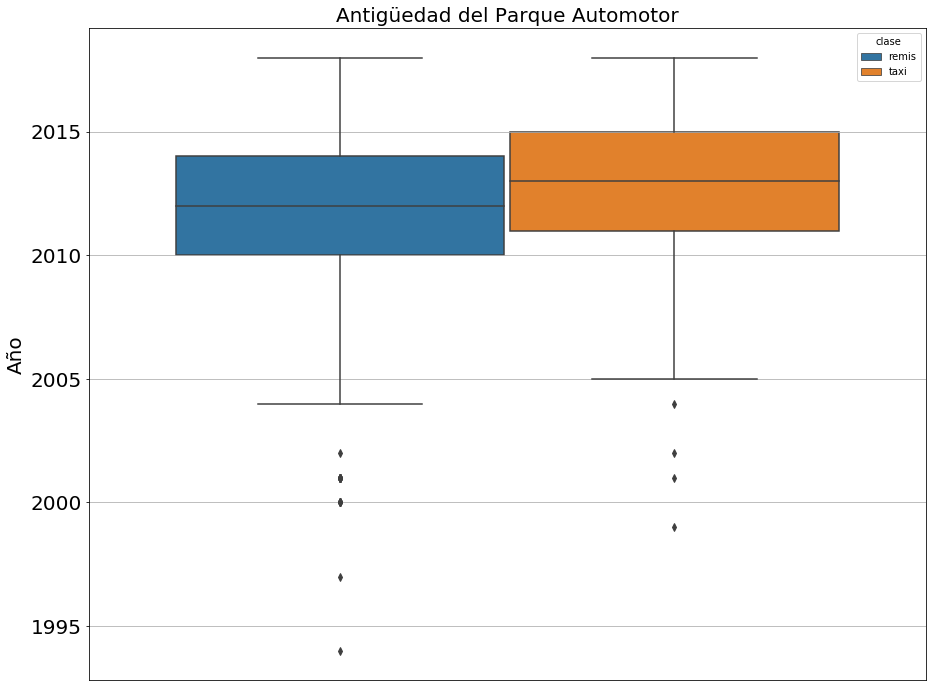

In [18]:
pd_in=pd_cat_raw[~pd_cat_raw.Patente.duplicated()].copy()
pd_in['dummy']=1
pd.set_option('precision', 1)
case_cols=pd_in[pd_in['Año']>1993].groupby('clase')['Año'].describe()
summary=pd.DataFrame(case_cols.values.T,index=case_cols.columns,columns=['remis','taxi'])
#
fig,ax=plt.subplots(1,1,figsize=(15,12))
sns.boxplot(x='dummy', y="Año",hue="clase", data=pd_in[pd_in['Año']>1993],ax=ax,hue_order=['remis','taxi'])
ax.grid('True')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('Año',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Antigüedad del Parque Automotor',fontsize=20);

/home/felix/anaconda3/envs/datosabiertos_cba/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


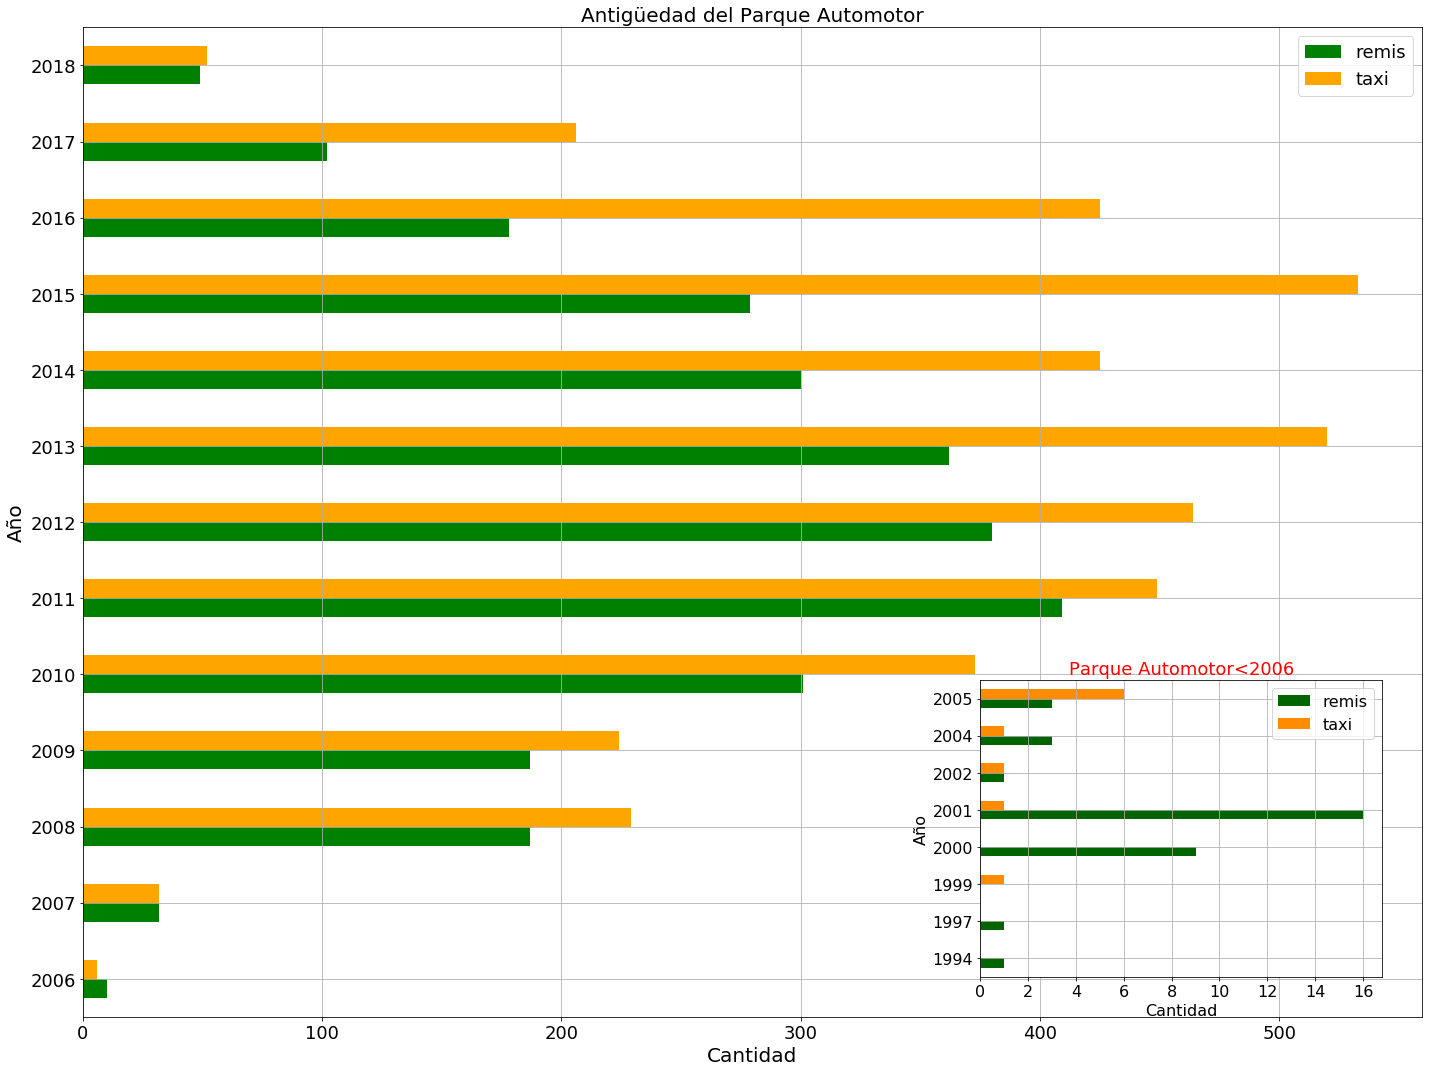

In [19]:
# version II
fig,ax=plt.subplots(1,1,figsize=(20,15))
base_year=2006
pd_in[pd_in['Año']>=base_year].groupby(by=['Año','clase']).count().unstack('clase')['Patente'].plot(kind='barh',ax=ax,fontsize=18,stacked=False,color=['green','orange'])
ax.set_title('Antigüedad del Parque Automotor',fontsize=20)
ax.set_ylabel('Año',fontsize=20)
ax.set_xlabel('Cantidad',fontsize=20)
ax.grid(True)
ax.legend(fontsize=18)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax2 = inset_axes(ax, width="30%", height="30%",loc=4,borderpad=4)
pd_in[np.logical_and(pd_in['Año']<base_year,pd_in['Año']>0)].groupby(by=['Año','clase']).count().unstack('clase')['Patente'].plot(kind='barh',ax=ax2,fontsize=16,stacked=False,color=['darkgreen','darkorange'])#
ax2.set_title('Parque Automotor<'+str(base_year),fontdict={'fontsize':18,'color':'red'})
ax2.set_ylabel('Año',fontsize=16)
ax2.set_xlabel('Cantidad',fontsize=16)
ax2.legend(fontsize=16)
ax2.grid(True)             
plt.tight_layout()
plt.savefig('img/parque_automotor_antiguedad.png')

### Marcas mas utilizadas

Mostramos las marcas mas utilizadas para las diferentes clases (taxis y remises). En el mismo grafico indicamos la cantidad de cada Marca.

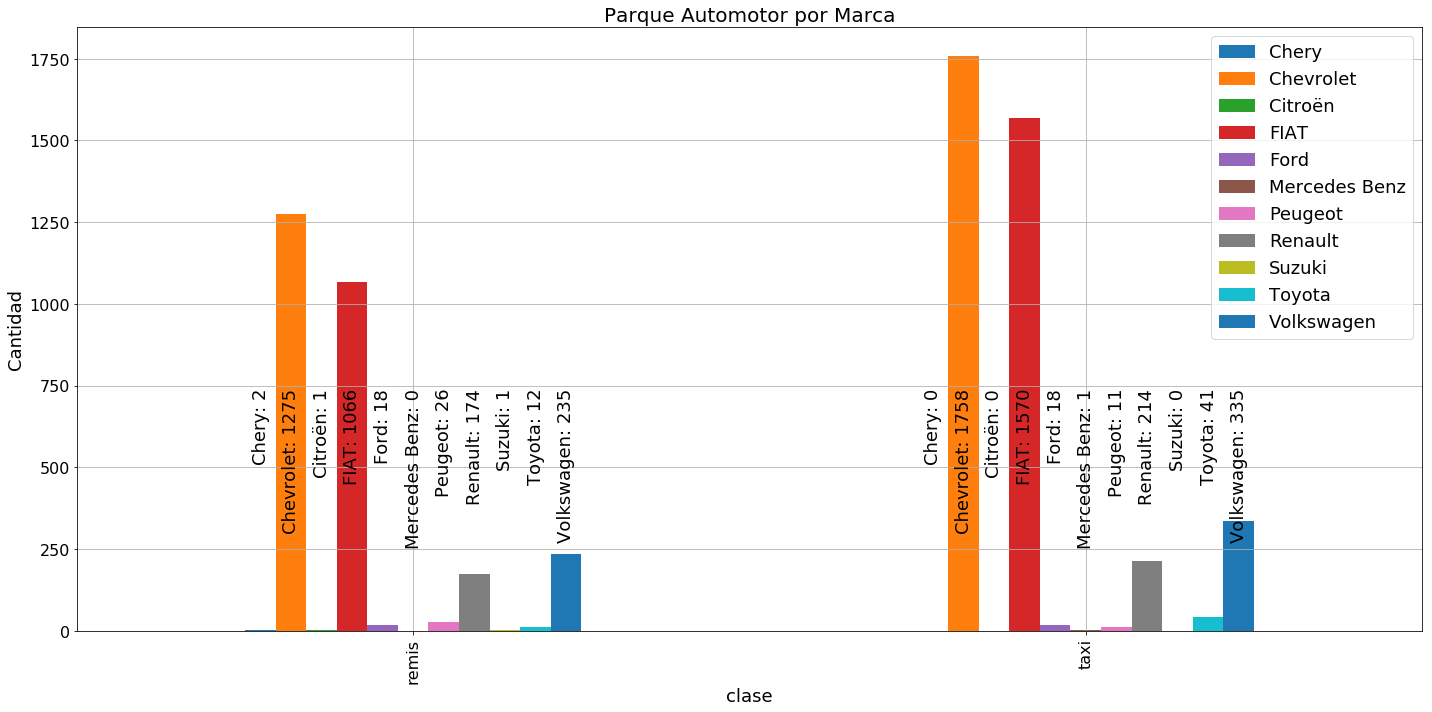

In [20]:
#helper
base_year=1994
pd_help=pd_in[pd_in['Año']>=base_year].groupby(by=['clase','Marca_upd']).count().unstack('Marca_upd')['Patente']
#
fig,ax=plt.subplots(1,1,figsize=(20,10))
bars=pd_in[pd_in['Año']>=base_year].groupby(by=['clase','Marca_upd']).count().unstack('Marca_upd')['Patente'].plot(kind='bar',ax=ax,fontsize=16,stacked=False)
ax.set_title('Parque Automotor por Marca',fontsize=20)
ax.set_ylabel('Cantidad',fontsize=18)
ax.set_xlabel('clase',fontsize=18)
ax.grid(True)
ax.legend(fontsize=18)
handles, labels = ax.get_legend_handles_labels()
for i, l in enumerate(labels):
    for x,c in zip([0,1],['remis','taxi']):
        plt.text(ax.containers[i][x].xy[0]+0.01,700,'{}: {:.0f}'.format(l,0 if np.isnan(pd_help.loc[c,l]) else pd_help.loc[c,l]),rotation=90,fontsize=18)
plt.tight_layout()
plt.savefig('img/parque_automotor_por_marca.png')

Adicionalmente mostramos el desglose por modelo para las 4 marcas mas utilizadas

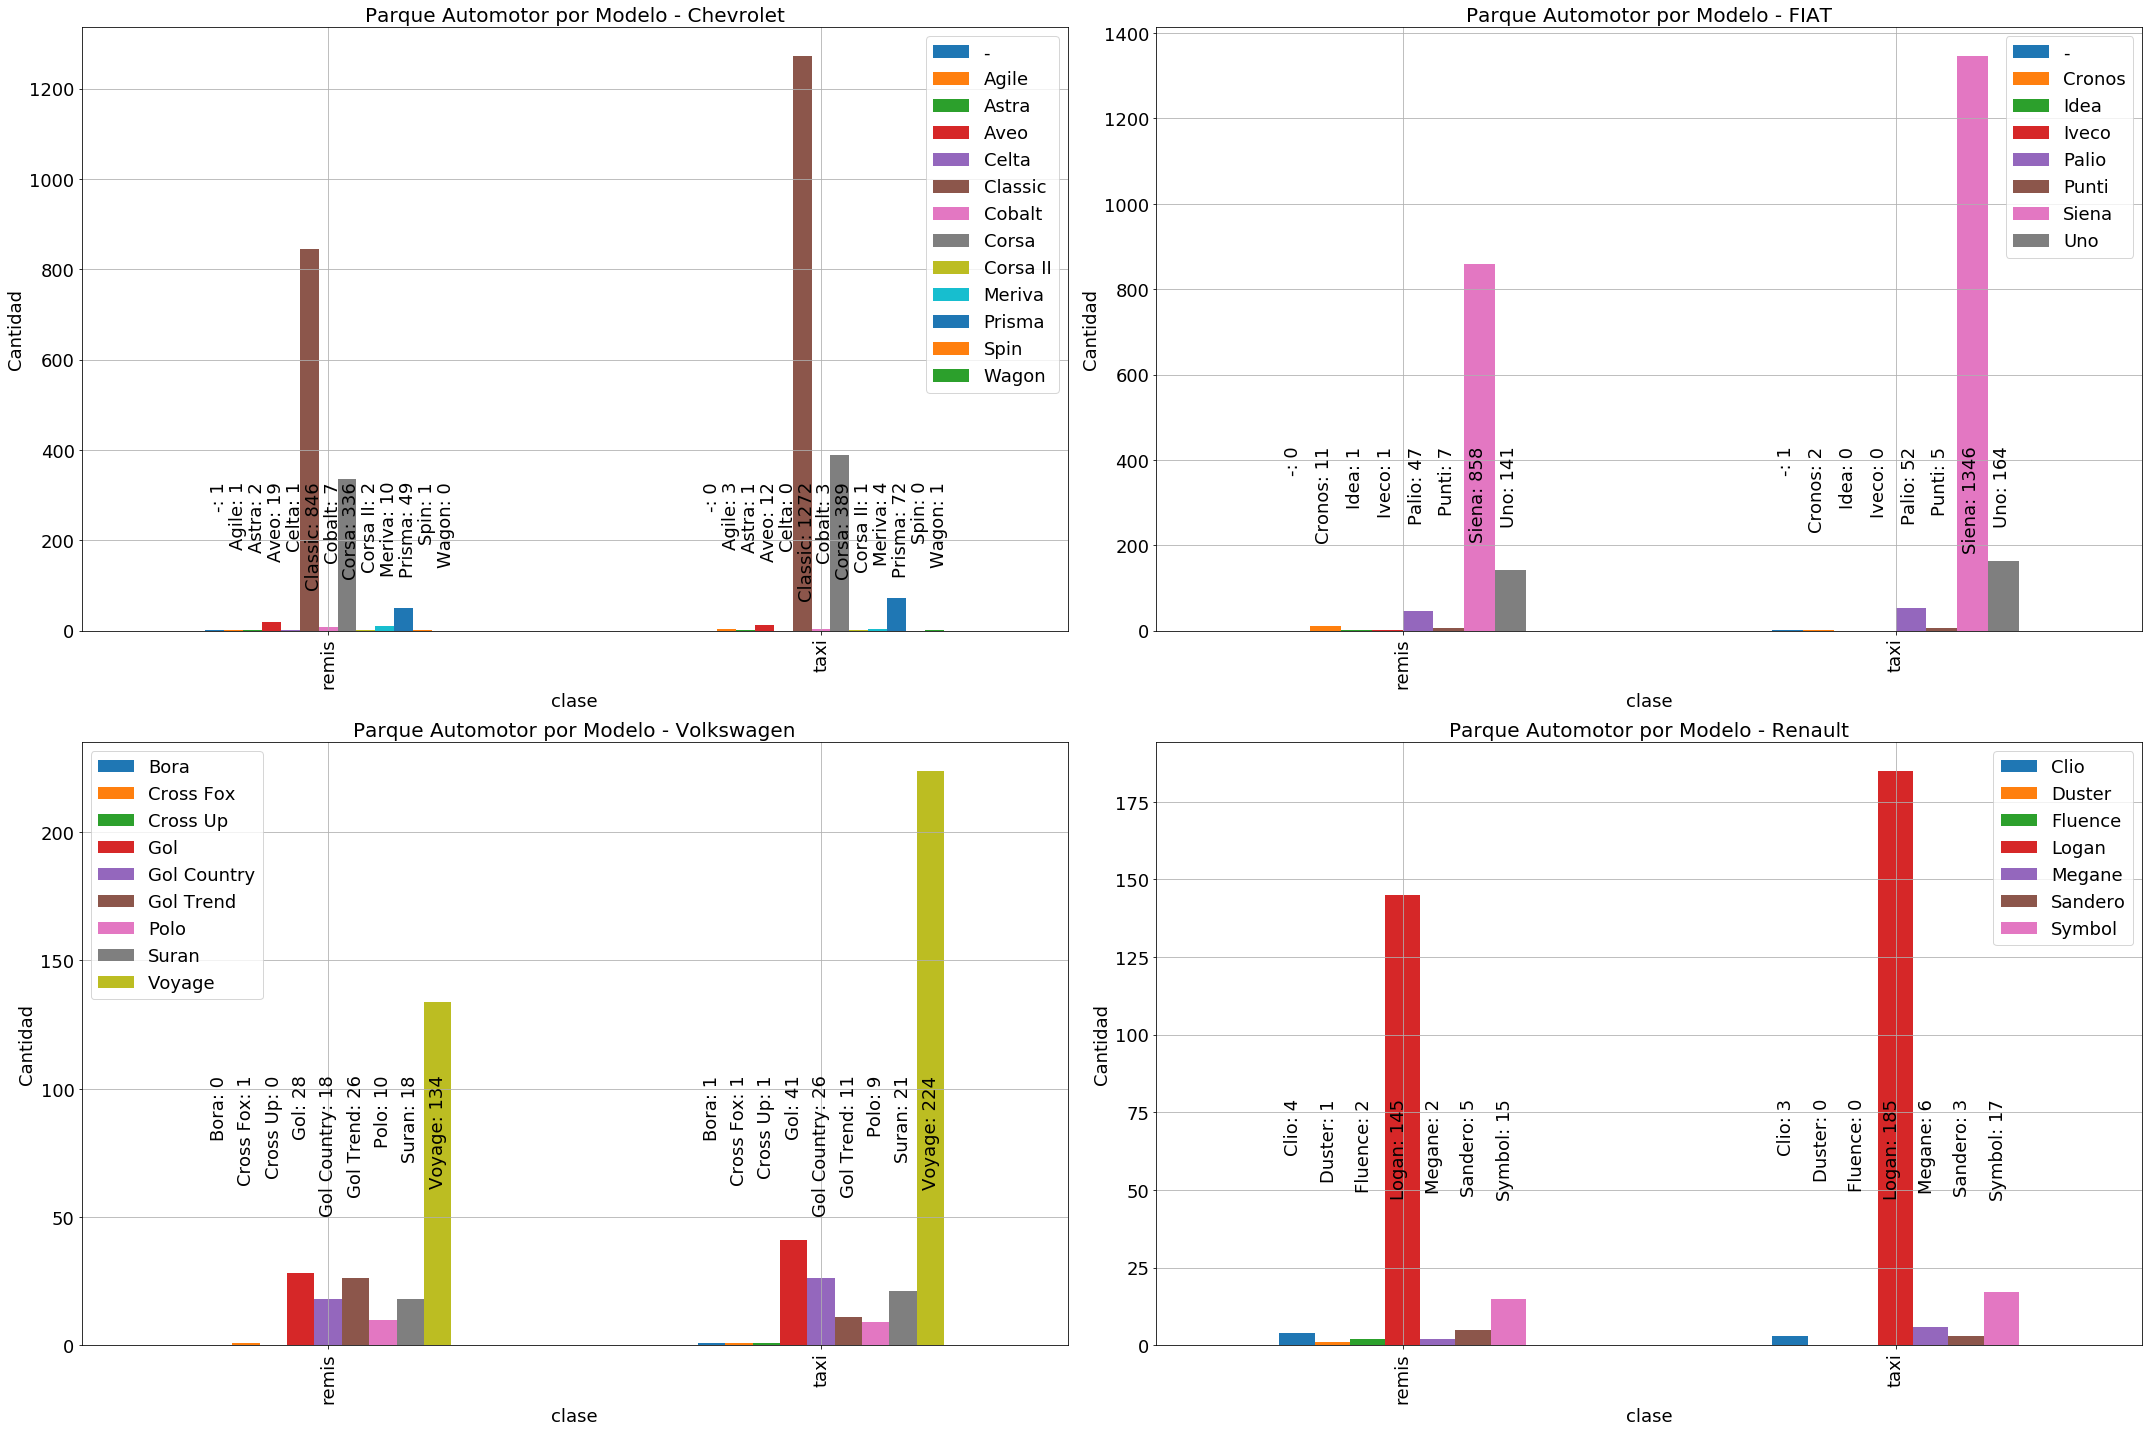

In [21]:
#helper
pd_in=pd_cat_raw[~pd_cat_raw.Patente.duplicated()].copy()
base_year=1994

fig=plt.figure(figsize=(30,20))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
yscale=[300,400,100,75]

for j,marca in enumerate(['Chevrolet','FIAT','Volkswagen','Renault']):
    pd_in=pd_cat_raw[~pd_cat_raw.Patente.duplicated()].copy()
    pd_in=pd_in[pd_in.Marca_upd==marca]
    pd_help=pd_in[pd_in['Año']>=base_year].groupby(by=['clase','Modelo']).count().unstack('Modelo')['Patente']
    ax = plt.subplot(gs[j])
    bars=pd_in[pd_in['Año']>=base_year].groupby(by=['clase','Modelo']).count().unstack('Modelo')['Patente'].plot(kind='bar',ax=ax,fontsize=18,stacked=False)
    ax.set_title('Parque Automotor por Modelo - '+ marca,fontsize=20)
    ax.set_ylabel('Cantidad',fontsize=18)
    ax.set_xlabel('clase',fontsize=18)
    ax.grid(True)
    ax.legend(fontsize=18)
    handles, labels = ax.get_legend_handles_labels()
    for i, l in enumerate(labels):
        for x,c in zip([0,1],['remis','taxi']):
            ax.text(ax.containers[i][x].xy[0]+0.01,yscale[j],'{}: {:.0f}'.format(l,0 if np.isnan(pd_help.loc[c,l]) else pd_help.loc[c,l]),rotation=90,fontsize=18)
plt.tight_layout()
plt.savefig('img/parque_automotor_por_modelo.png')

## Licencias Habilitadas en Taxis y Remis para una misma Patente

En el analisis se detecto que existen instancias en las cuales un mismo vehiculo consta tanto con las licencias de Taxi como de Remis.

In [22]:
pd_helper=pd_cat_raw[pd_cat_raw.duplicated(subset=['Patente'],keep=False)].groupby(by=['Patente','clase'])['Titular'].count().unstack()
pd_helper.dropna()

clase,remis,taxi
Patente,,
AA782EA,1.0,1.0
AA814WC,1.0,1.0
KDM472,1.0,1.0
KWI327,1.0,1.0
POT175,1.0,1.0


Observamos que tenemos 5 instancias en las cuales tenemos licencias habilitantes tanto de taxi como remis para un mismo vehiculo (misma patente). Ahora utilizamos esta informacion para obtener el conjunto total.

In [23]:
index_helper=pd_helper.dropna().index
pd_drop=pd_cat_raw[~pd_cat_raw.Patente.isnull()].copy()
pd_drop=pd_drop[~pd_drop.CUIT.isnull()].copy()
pd_drop.CUIT=pd_drop.CUIT.astype(np.int)
pd_temp=pd_drop.set_index('Patente')
pd_temp.loc[index_helper,:]

,Titular,CUIT,Marca,Modelo,Año,estado,clase,Marca_upd
Patente,,,,,,,,
AA782EA,MOLL NORA BEATRIZ,12671032,FIAT,Palio,2016,Habilitado,remis,FIAT
AA782EA,FAUDA HUGO WALTER,16904435,FIAT,Palio,2016,Habilitado,taxi,FIAT
AA814WC,ZITTA ALEJANDRO,14155774,Toyota,Etios,2016,Habilitado,remis,Toyota
AA814WC,CONTRERAS GUSTAVO ARIEL,23089541,Toyota,Etios,2016,Habilitado,taxi,Toyota
KDM472,MERCAU MARIA CANDELARIA,35054714,Chevrolet,Classic,2011,Habilitado,remis,Chevrolet
KDM472,GARAY ANA MARIA,18374643,Chevrolet,Classic,2011,Habilitado,taxi,Chevrolet
KWI327,SAMPO JAVIER LUIS ESTEBAN,28652026,Chevrolet,Classic,2012,Habilitado,remis,Chevrolet
KWI327,CARUSO CONCEPCION,5008435,Chevrolet,Corsa,2012,Habilitado,taxi,Chevrolet
POT175,YABALE MARIO GONZALO,26844562,Chevrolet,Classic,2016,Habilitado,remis,Chevrolet


In [24]:
# from  https://github.com/andrewblane/DataFrame_to_image
# mofified to load css by default
def DataFrame_to_image(data, css='', outputfile="out.png", format="png"):
    '''
    For rendering a Pandas DataFrame as an image.
    data: a pandas DataFrame
    css: a string containing rules for styling the output table. This must 
         contain both the opening an closing <style> tags.
    *outputimage: filename for saving of generated image
    *format: output format, as supported by IMGKit. Default is "png"
    '''
    import numpy as np
    fn = str(np.random.random()*100000000).split(".")[0] + ".html"
    
    if css=='':
        # modified from http://cssmenumaker.com/br/blog/stylish-css-tables-tutorial
        css = """
        <style type=\"text/css\">
        table {
        color: #333;
        font-family: Helvetica, Arial, sans-serif;
        width: 640px;
        border-collapse:
        collapse; 
        border-spacing: 0;
        }

        td, th {
        border: 1px solid transparent; /* No more visible border */
        height: 30px;
        }

        th {
        background: #DFDFDF; /* Darken header a bit */
        font-weight: bold;
        }

        td {
        background: #FAFAFA;
        text-align: center;
        }

        table tr:nth-child(odd) td{
        background-color: white;
        }
        </style>
        """
   
    try:
        os.remove(fn)
    except:
        None
    text_file = open(fn, "w")
    
    # write the CSS
    text_file.write(css)
    # write the HTML-ized Pandas DataFrame
    text_file.write(data.to_html())
    text_file.close()
    
    # See IMGKit options for full configuration,
    # e.g. cropping of final image
    imgkitoptions = {"format": format}
    
    imgkit.from_file(fn, outputfile, options=imgkitoptions)
    os.remove(fn)

In [25]:
# Exportamos la tabla
DataFrame_to_image(pd_temp.loc[index_helper,:].drop(labels=['Titular','Año','Marca_upd'],axis=1),outputfile='img/lic_tax_rem_patente.png')

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


## Licencias Habilitadas en Taxis y Remis para un mismo CUIT

Ahora vemos las licencias de taxi y remis habilitadas para un mismo CUIT en simultaneo.

In [26]:
pd_drop=pd_cat_raw[~pd_cat_raw.CUIT.isnull()].copy()
pd_drop.CUIT=pd_drop.CUIT.astype(np.int)
pd_helper=pd_drop.groupby(by=['CUIT','clase'])
pd_helper['Patente'].count().unstack('clase').dropna()

clase,remis,taxi
CUIT,,
6437852,1.0,1.0
8651992,1.0,1.0
11195523,1.0,2.0
26490111,1.0,1.0


Observamos que tenemos dos situaciones:
- Licencias cruzadas: La norma parece indicar que pueden tenerse un maximo de 2 licencias de un único tipo
- Más licencias de las permitidas


In [27]:
index_helper=pd_helper['Patente'].count().unstack('clase').dropna().index
pd_temp=pd_drop.set_index('CUIT')
pd_temp.loc[index_helper,:]

,Titular,Patente,Marca,Modelo,Año,estado,clase,Marca_upd
CUIT,,,,,,,,
6437852,CUELLO AMADEO ANTONIO,OEB442,Chevrolet,Classic,2014,Habilitado,remis,Chevrolet
6437852,CUELLO AMADEO ANTONIO,KYQ319,FIAT,Siena,2012,Habilitado,taxi,FIAT
8651992,TULIAN ARMANDO RAMON,HUT122,FIAT,Siena,2009,Habilitado,remis,FIAT
8651992,TULIAN ARMANDO RAMON,KUJ583,FIAT,Siena,2012,Habilitado,taxi,FIAT
11195523,CATANI TERCILIO,OMY278,FIAT,Siena,2015,Habilitado,remis,FIAT
11195523,CATANI TERCILIO,OYU673,FIAT,Siena,2015,Habilitado,taxi,FIAT
11195523,CATANI TERCILIO,PQC231,FIAT,Siena,2016,Habilitado,taxi,FIAT
26490111,PEREYRA MARCELO,LGL439,FIAT,Siena,2012,Habilitado,remis,FIAT
26490111,PEREYRA MARCELO ALEJANDRO,AA398PY,FIAT,Siena,2016,Habilitado,taxi,FIAT


In [28]:
# Exportamos la tabla
DataFrame_to_image(pd_temp.loc[index_helper,:].drop(labels=['Titular','Año','Marca_upd'],axis=1),outputfile='img/lic_tax_rem_cuit.png')

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


### Agentes Municipales y Licencias

Para ir cerrando analizamos la posibilidad de que Agentes municipales posean licencias (esto segun la normativa esta prohibido).
La Nomina de agentes la obtuvimos en el [sitio](https://gobiernoabierto.cordoba.gob.ar/data/datos-abiertos/categoria/agentes-municipales/nomina-de-agentes-municipales/201) de datos abiertos (mas precisamente utilizamos https://gobiernoabierto.cordoba.gob.ar/media/datos/Sueldos-julio-2018--.xlsx)

**La nomina no contiene el DNI o CUIT del agente por lo que el cruce de datos se realizó utilizando el NOMBRE y APELLIDO. Esto claramente no es lo ideal, pero en los casos en los cuales
haya coincidencia valdria la pena revisarlos.**


In [29]:
# Cargamos los Datos
pd_emp=pd.read_csv('data/Sueldos-julio-2018--.csv')
pd_emp.head()

,APELLIDO Y NOMBRE,SEXO,CGO,PROGRAMA,REPARTICION,IMPORTE
0,DIAZ MARIA TERESA,FEMENINO,5608,616000,DIRECCION DE ESPECIALIDADES MEDICAS,"24814,9"
1,ESTRELLA CARLOS EDUARDO,MASCULINO,615,738000,DIRECCION DE REDES SANITARIAS Y GAS - PTAS.,"30506,8"
2,CAPODAQUA GLADIS ALICIA,FEMENINO,613,961000,DIRECCION GENERAL DE CULTURA Y PATRIMONIOS,"28814,9"
3,GALARZA ISABEL CASILDA,FEMENINO,518,211000,DIRECCION DE CPC N* 1 CENTRO AMERICA,"32839,99"
4,FOX LUCIA SARA,FEMENINO,309,212000,DIRECCION DE CPC N* 2 MONSEÐOR PABLO CABRERA,"37759,7"


In [30]:
# Realizamos el merge correspondiente
pd_temp=pd.merge(pd_emp,pd_cat_raw,how='outer',left_on='APELLIDO Y NOMBRE',right_on='Titular',indicator=True)

In [31]:
# Al realizar el merge nos interesan aquellos casos que viven en ambos DataFrames: 'both'
pd_match=pd_temp[pd_temp._merge=='both'].copy()
pd_match.CUIT=pd_match.CUIT.astype(int)
pd_match[~pd_match['APELLIDO Y NOMBRE'].duplicated()][['APELLIDO Y NOMBRE','REPARTICION','Titular','CUIT']]


,APELLIDO Y NOMBRE,REPARTICION,Titular,CUIT
98,GOMEZ JORGE ALBERTO,ADMINISTRACION DE CEMENTERIO SAN JERONIMO,GOMEZ JORGE ALBERTO,5070599
270,JUAREZ JUAN CARLOS,DIRECCION GENERAL DE RECURSOS TRIBUTARIOS,JUAREZ JUAN CARLOS,18094799
403,CEBALLOS JUAN CARLOS,DIRECCION DE POLICIA MUNICIPAL,CEBALLOS JUAN CARLOS,16082701
468,ROMERO MARIA ROSA,EDUCACION ESC. DE BO.CENTRO AMERICA,ROMERO MARIA ROSA,14274903
616,FERREYRA JUAN CARLOS,DIR.REDES SANIT.Y GAS - PTA.B.DE PIEDRA,FERREYRA JUAN CARLOS,14537990
814,GOMEZ DANIEL ALEJANDRO,"DIRECCION GRAL.DE DEFENSA CIVIL, CAP. Y EMERGE...",GOMEZ DANIEL ALEJANDRO,22223662
835,GONZALEZ GUSTAVO GABRIEL,DIRECCION GENERAL DE CULTURA Y PATRIMONIOS - P...,GONZALEZ GUSTAVO GABRIEL,18014502
870,CORREA JUAN CARLOS,DIRECCION DE REDES SANITARIAS Y GAS - PTAS.,CORREA JUAN CARLOS,7630908
893,FERREYRA HUGO CESAR,DIRECCION DE POLICIA MUNICIPAL,FERREYRA HUGO CESAR,21901258
1254,GONZALEZ RODOLFO EDUARDO,DIRECCION DE POLICIA MUNICIPAL,GONZALEZ RODOLFO EDUARDO,21902275


In [32]:
pd_match[~pd_match['APELLIDO Y NOMBRE'].duplicated()][['APELLIDO Y NOMBRE','REPARTICION','Titular','CUIT']].shape

(47, 4)

Tenemos entonces 47 **posibles** situaciones en las cuales un empleado municipal **puede ser** titular de una licencia de Taxi y/o Remis